# 1. National Health and Nutrition Health Survey 2013-2014 (NHANES) Age Prediction Subset


In [13]:
import sys
!"{sys.executable}" -m pip install ucimlrepo


In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
national_health_and_nutrition_health_survey_2013_2014_nhanes_age_prediction_subset = fetch_ucirepo(id=887) 
  
# data (as pandas dataframes) 
X = national_health_and_nutrition_health_survey_2013_2014_nhanes_age_prediction_subset.data.features 
y = national_health_and_nutrition_health_survey_2013_2014_nhanes_age_prediction_subset.data.targets 
  
# metadata 
print(national_health_and_nutrition_health_survey_2013_2014_nhanes_age_prediction_subset.metadata) 
  
# variable information 
print(national_health_and_nutrition_health_survey_2013_2014_nhanes_age_prediction_subset.variables) 


{'uci_id': 887, 'name': 'National Health and Nutrition Health Survey 2013-2014 (NHANES) Age Prediction Subset', 'repository_url': 'https://archive.ics.uci.edu/dataset/887/national+health+and+nutrition+health+survey+2013-2014+(nhanes)+age+prediction+subset', 'data_url': 'https://archive.ics.uci.edu/static/public/887/data.csv', 'abstract': "The National Health and Nutrition Examination Survey (NHANES), administered by the Centers for Disease Control and Prevention (CDC), collects extensive health and nutritional information from a diverse U.S. population. Though expansive, the dataset is often too broad for specific analytical purposes. In this sub-dataset, we narrow our focus to predicting respondents' age by extracting a subset of features from the larger NHANES dataset. These selected features include physiological measurements, lifestyle choices, and biochemical markers, which were hypothesized to have strong correlations with age.", 'area': 'Health and Medicine', 'tasks': ['Classifi

### Import


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### Convert categorical target labels (e.g., 'Graduate') into integers (0,1,2)

In [5]:
from sklearn.preprocessing import LabelEncoder

# -----------------------------
# 1) Load dataset
# -----------------------------
dataset = fetch_ucirepo(id=887)

X = dataset.data.features.values.astype(np.float32)
y = dataset.data.targets.values.ravel()   # flatten to 1D

# Convert categorical target labels (e.g., 'Graduate') into integers (0,1,2)
le = LabelEncoder()
y = le.fit_transform(y)

num_classes = len(np.unique(y))
print("Number of classes:", num_classes)
print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Number of classes: 2
Class mapping: {'Adult': np.int64(0), 'Senior': np.int64(1)}


### Train/ Val / Test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Convert targets to numpy arrays explicitly (fix for TensorDataset)
y_train = np.array(y_train, dtype=np.int64)
y_val   = np.array(y_val, dtype=np.int64)
y_test  = np.array(y_test, dtype=np.int64)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

### Build PyTorch Datasets

In [7]:
train_ds = TensorDataset(
    torch.from_numpy(X_train),
    torch.from_numpy(y_train).long()
)
val_ds = TensorDataset(
    torch.from_numpy(X_val),
    torch.from_numpy(y_val).long()
)
test_ds = TensorDataset(
    torch.from_numpy(X_test),
    torch.from_numpy(y_test).long()
)

batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

### Define the model

In [8]:
input_dim = X_train.shape[1]

model = nn.Sequential(
    nn.Linear(input_dim, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, num_classes)  # num_classes = 3 (Dropout, Enrolled, Graduate)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### Training Loop

In [9]:
def evaluate(loader):
    model.eval()
    total_loss, total_correct, total_count = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == yb).sum().item()
            total_count += xb.size(0)
    return total_loss / total_count, total_correct / total_count

epochs = 50
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(1, epochs+1):
    model.train()
    running_loss, running_correct, running_count = 0.0, 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds == yb).sum().item()
        running_count += xb.size(0)

    train_epoch_loss = running_loss / running_count
    train_epoch_acc  = running_correct / running_count
    val_epoch_loss, val_epoch_acc = evaluate(val_loader)

    history['train_loss'].append(train_epoch_loss)
    history['val_loss'].append(val_epoch_loss)
    history['train_acc'].append(train_epoch_acc)
    history['val_acc'].append(val_epoch_acc)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d}/{epochs} | "
              f"train_loss={train_epoch_loss:.4f} val_loss={val_epoch_loss:.4f} "
              f"train_acc={train_epoch_acc:.4f} val_acc={val_epoch_acc:.4f}")


Epoch 01/50 | train_loss=0.4567 val_loss=0.4022 train_acc=0.8380 val_acc=0.8411
Epoch 05/50 | train_loss=0.3771 val_loss=0.3834 train_acc=0.8421 val_acc=0.8411
Epoch 10/50 | train_loss=0.3663 val_loss=0.3828 train_acc=0.8545 val_acc=0.8466
Epoch 15/50 | train_loss=0.3589 val_loss=0.3846 train_acc=0.8566 val_acc=0.8411
Epoch 20/50 | train_loss=0.3538 val_loss=0.3889 train_acc=0.8552 val_acc=0.8356
Epoch 25/50 | train_loss=0.3464 val_loss=0.3972 train_acc=0.8614 val_acc=0.8356
Epoch 30/50 | train_loss=0.3395 val_loss=0.4090 train_acc=0.8641 val_acc=0.8329
Epoch 35/50 | train_loss=0.3361 val_loss=0.4091 train_acc=0.8641 val_acc=0.8329
Epoch 40/50 | train_loss=0.3296 val_loss=0.4143 train_acc=0.8627 val_acc=0.8384
Epoch 45/50 | train_loss=0.3248 val_loss=0.4149 train_acc=0.8627 val_acc=0.8274
Epoch 50/50 | train_loss=0.3163 val_loss=0.4267 train_acc=0.8675 val_acc=0.8301


### Evaluation on Test Set

In [10]:
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(yb.numpy())

print("\nClassification Report:")
print(classification_report(all_true, all_preds, target_names=le.classes_))


Classification Report:
              precision    recall  f1-score   support

       Adult       0.86      0.96      0.90       383
      Senior       0.41      0.16      0.24        73

    accuracy                           0.83       456
   macro avg       0.64      0.56      0.57       456
weighted avg       0.79      0.83      0.80       456



### Confusion Matrix

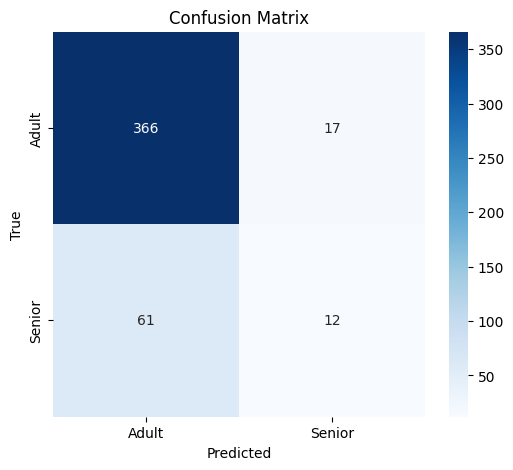

In [11]:
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


### Learning Curve

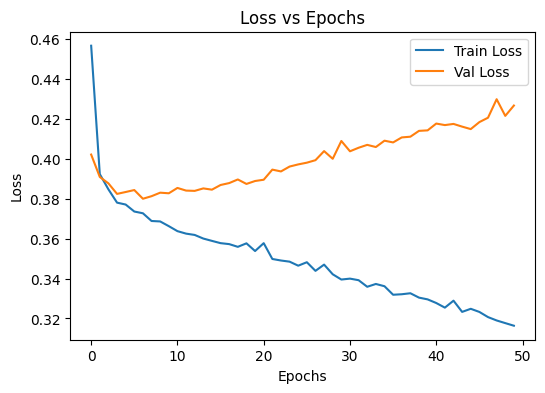

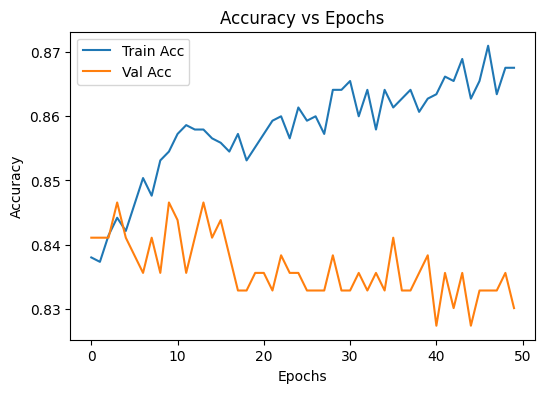

In [12]:
plt.figure(figsize=(6, 4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss vs Epochs')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy vs Epochs')
plt.show()

# 2. Predict Students' Dropout and Academic Success

##  Improved Model for Student Dropout Prediction

In this updated version of the model, several changes were made to improve performance and generalization compared to the first version:

1. **Deeper Neural Network**  
   - Increased the number of layers from 2 → 3 fully connected layers.  
   - Added more neurons (128 → 64 → 32) to allow the model to learn more complex patterns.  

2. **Dropout Regularization**  
   - Added `Dropout(0.3)` after hidden layers to reduce overfitting.  
   - This forces the network to learn more robust features.  

3. **Learning Rate Scheduler**  
   - Introduced `StepLR` to gradually reduce the learning rate during training.  
   - Helps the optimizer converge more smoothly and avoid local minima.  

4. **Longer Training (More Epochs)**  
   - Increased training epochs (e.g., 20+) to allow the model to fully learn.  
   - With dropout + scheduler, longer training does not overfit as quickly.  

### Expected Outcome
- Better generalization on the validation/test set.  
- More stable accuracy and loss curves.  
- Improved performance especially for minority classes (`Dropout`, `Enrolled`, `Graduate`).  

---


### Import Dataset

In [14]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
  
# data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features 
y = predict_students_dropout_and_academic_success.data.targets 
  
# metadata 
print(predict_students_dropout_and_academic_success.metadata) 
  
# variable information 
print(predict_students_dropout_and_academic_success.variables) 

{'uci_id': 697, 'name': "Predict Students' Dropout and Academic Success", 'repository_url': 'https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success', 'data_url': 'https://archive.ics.uci.edu/static/public/697/data.csv', 'abstract': "A dataset created from a higher education institution (acquired from several disjoint databases) related to students enrolled in different undergraduate degrees, such as agronomy, design, education, nursing, journalism, management, social service, and technologies.\nThe dataset includes information known at the time of student enrollment (academic path, demographics, and social-economic factors) and the students' academic performance at the end of the first and second semesters. \nThe data is used to build classification models to predict students' dropout and academic sucess. The problem is formulated as a three category classification task, in which there is a strong imbalance towards one of the classes.", 'area': 'Social Sc

### Import


In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo

### Load Data Set

In [17]:
dataset = fetch_ucirepo(id=697)
X = dataset.data.features.values.astype(np.float32)
y = dataset.data.targets.values.ravel()

# Encode string labels to integers
le = LabelEncoder()
y = le.fit_transform(y)
num_classes = len(np.unique(y))
print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Class mapping: {'Dropout': np.int64(0), 'Enrolled': np.int64(1), 'Graduate': np.int64(2)}


### Train/Val/Split Set

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

### Build Pytorch Datasets

In [19]:
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train).long())
val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val).long())
test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test).long())

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

### Define the model

In [20]:
class EfficientMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientMLP(X_train.shape[1], num_classes).to(device)


### Loss function with Class weights

In [22]:
from sklearn.utils import compute_class_weight


class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

### Training loop with early stopping


In [23]:
epochs = 50
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

best_val_loss = float('inf')
patience = 7
trigger_times = 0

def evaluate(loader):
    model.eval()
    total_loss, total_correct, total_count = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == yb).sum().item()
            total_count += xb.size(0)
    return total_loss / total_count, total_correct / total_count

for epoch in range(1, epochs+1):
    model.train()
    running_loss, running_correct, running_count = 0.0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds == yb).sum().item()
        running_count += xb.size(0)

    train_epoch_loss = running_loss / running_count
    train_epoch_acc  = running_correct / running_count
    val_epoch_loss, val_epoch_acc = evaluate(val_loader)

    scheduler.step(val_epoch_loss)

    history['train_loss'].append(train_epoch_loss)
    history['val_loss'].append(val_epoch_loss)
    history['train_acc'].append(train_epoch_acc)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch:02d}/{epochs} | "
          f"train_loss={train_epoch_loss:.4f} val_loss={val_epoch_loss:.4f} "
          f"train_acc={train_epoch_acc:.4f} val_acc={val_epoch_acc:.4f}")

    # Early stopping
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered!")
            break


Epoch 01/50 | train_loss=0.9181 val_loss=0.7699 train_acc=0.6026 val_acc=0.7119
Epoch 02/50 | train_loss=0.7611 val_loss=0.7124 train_acc=0.7026 val_acc=0.7246
Epoch 03/50 | train_loss=0.7363 val_loss=0.7004 train_acc=0.6990 val_acc=0.7316
Epoch 04/50 | train_loss=0.6949 val_loss=0.6943 train_acc=0.7315 val_acc=0.7316
Epoch 05/50 | train_loss=0.6901 val_loss=0.6914 train_acc=0.7358 val_acc=0.7302
Epoch 06/50 | train_loss=0.6706 val_loss=0.6781 train_acc=0.7443 val_acc=0.7260
Epoch 07/50 | train_loss=0.6653 val_loss=0.6853 train_acc=0.7404 val_acc=0.7316
Epoch 08/50 | train_loss=0.6670 val_loss=0.6778 train_acc=0.7499 val_acc=0.7218
Epoch 09/50 | train_loss=0.6515 val_loss=0.6741 train_acc=0.7418 val_acc=0.7472
Epoch 10/50 | train_loss=0.6457 val_loss=0.6804 train_acc=0.7425 val_acc=0.7373
Epoch 11/50 | train_loss=0.6268 val_loss=0.6788 train_acc=0.7630 val_acc=0.7246
Epoch 12/50 | train_loss=0.6412 val_loss=0.6811 train_acc=0.7513 val_acc=0.7274
Epoch 13/50 | train_loss=0.6345 val_loss

### Evaluation set

In [24]:
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(yb.numpy())

print("\nClassification Report:")
print(classification_report(all_true, all_preds, target_names=le.classes_))


Classification Report:
              precision    recall  f1-score   support

     Dropout       0.83      0.68      0.75       284
    Enrolled       0.38      0.62      0.47       159
    Graduate       0.85      0.76      0.81       442

    accuracy                           0.71       885
   macro avg       0.69      0.69      0.68       885
weighted avg       0.76      0.71      0.73       885



### Confusion Matrix

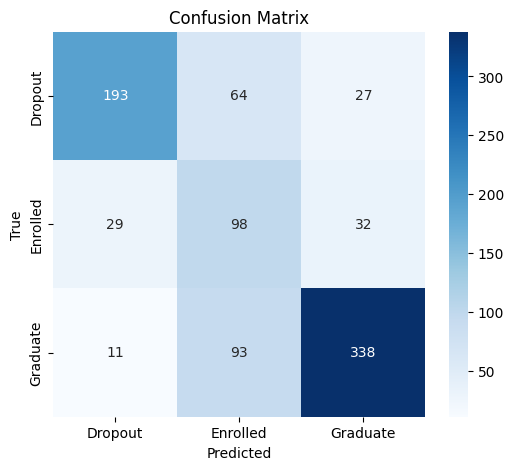

In [25]:
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Learning Curve

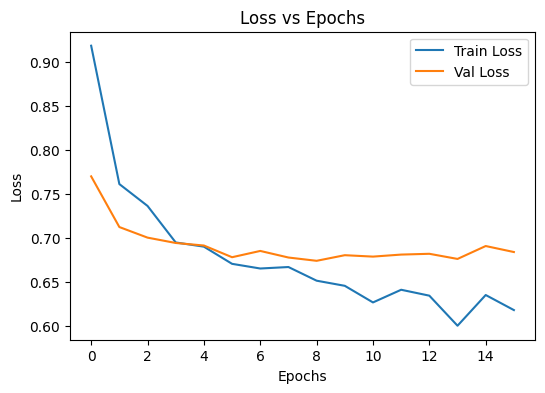

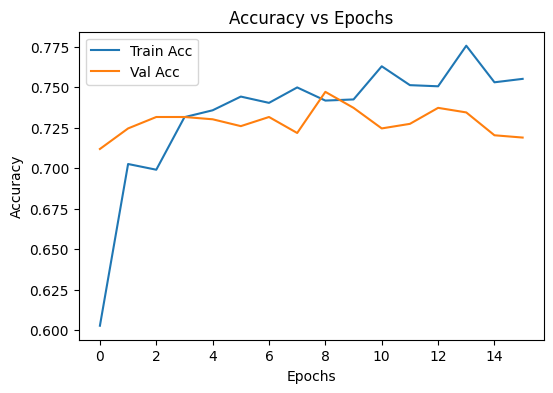

In [26]:
plt.figure(figsize=(6,4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss vs Epochs')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy vs Epochs')
plt.show()